In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from transformers import AdamW
import pandas as pd
from transformers import BertTokenizer, BertModel, BertConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import csv
import re
import validators
import emoji
import unidecode
import nltk
import pickle
nltk.download('stopwords')

C:\Users\admin\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Set the seed for reproducibility
SEED = 1237
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# BERT Hyperparameters (ADDITION)
n_bert_layers = 16  # Assuming the base model has 12 layers
bert_lr = 0.001
pooling_strategy = 'cls'  # Options: 'cls', 'mean', 'max'
bert_hidden_size = 768  # Adjust based on your BERT model
max_seq_length = 128
fine_tune_strategy = 'full'  # Options: 'full', 'last_layer'
bert_dropout = 0.9  # Adjust based on BERT model specifications

max_seq_length = 128  # This should match the max_seq_length used in BERT model
padding_strategy = 'max_length'  # Options: 'max_length', 'do_not_pad', 'longest'
truncation_strategy = 'longest_first'  # Options: 'longest_first', 'only_first', 'only_second'
do_lower_case = True  # Set to False if using a cased model

config = BertConfig(
    num_hidden_layers=n_bert_layers,
    hidden_size=bert_hidden_size,
    num_attention_heads=24,  # Assuming 12 attention heads
    intermediate_size=4 * bert_hidden_size,  # Default value in BERT
    hidden_dropout_prob=bert_dropout,
    attention_probs_dropout_prob=bert_dropout,
)

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          max_length=max_seq_length,
                                          padding=padding_strategy,
                                          truncation=truncation_strategy,
                                          do_lower_case=do_lower_case)
# Load the BERT model with the custom configuration
bert_model = BertModel(config=config)

In [3]:
data_path = "C:/Users/admin/Downloads/multilabel-dataset.csv"  
data_df = pd.read_csv(data_path)
data_df = data_df.rename(columns={'Tweet Content': 'text', 'Sentiment': 'sentiment', 'Label': 'label'})

In [4]:
data_df

,text,sentiment,label
0,Dictator's son on the cusp of power in the #Ph...,Negative,Hate
1,Kung ang definition ni BongBong Marcos sa isan...,Negative,Hate
2,Leni Robredo is not being subjected by her opp...,Negative,Hate
3,@imstillsour Tuwang tuwa sila sa Pink hahaha.....,Negative,Hate
4,Kapag hindi si VP Leni Robredo ang iboboto mo ...,Negative,Hate
...,...,...,...
7675,VP LENI ROBREDO FOR 2022 https://t.co/2ahSefgmST,Neutral,Non-hate
7676,@alt_ego143 @rapplerdotcom @ramboreports hindi...,Neutral,Non-hate
7677,"I can't vote yet, but my president is Leni Rob...",Neutral,Non-hate
7678,Anyways President Leni Robredo #SaveLegendsOfT...,Neutral,Non-hate


In [5]:
# Preprocessing function
def preprocess_text(text):
    tokens = tokenizer.tokenize(text)
    tokens = tokens[:tokenizer.model_max_length - 2]  # Account for [CLS] and [SEP] tokens
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokens)
    return indexed_tokens

filipino_stopwords = set(
    """
akin
aking
ako
alin
am
amin
aming
ang
ano
anumang
apat
at
atin
ating
ay
bababa
bago
bakit
bawat
bilang
dahil
dalawa
dapat
din
dito
doon
gagawin
gayunman
ginagawa
ginawa
ginawang
gumawa
gusto
habang
hanggang
hindi
huwag
iba
ibaba
ibabaw
ibig
ikaw
ilagay
ilalim
ilan
inyong
isa
isang
itaas
ito
iyo
iyon
iyong
ka
kahit
kailangan
kailanman
kami
kanila
kanilang
kanino
kanya
kanyang
kapag
kapwa
karamihan
katiyakan
katulad
kaya
kaysa
ko
kong
kulang
kumuha
kung
laban
lahat
lamang
likod
lima
maaari
maaaring
maging
mahusay
makita
marami
marapat
masyado
may
mayroon
mga
minsan
mismo
mula
muli
na
nabanggit
naging
nagkaroon
nais
nakita
namin
napaka
narito
nasaan
ng
ngayon
ni
nila
nilang
nito
niya
niyang
noon
o
pa
paano
pababa
paggawa
pagitan
pagkakaroon
pagkatapos
palabas
pamamagitan
panahon
pangalawa
para
paraan
pareho
pataas
pero
pumunta
pumupunta
sa
saan
sabi
sabihin
sarili
sila
sino
siya
tatlo
tayo
tulad
tungkol
una
walang
""".split()
)

# Date De-Identification
def remove_mentions(text):
    mention_pattern = re.compile(r'@\w+')
    
    # Use re.sub to remove mentions
    cleaned_text = mention_pattern.sub('', text)
    
    # Remove extra spaces and strip leading/trailing spaces
    cleaned_text = ' '.join(cleaned_text.split())

    return cleaned_text

# URL Removal
def remove_url(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    
    # Use re.sub to remove URLs
    cleaned_text = url_pattern.sub('', text)
    
    # Remove extra spaces and strip leading/trailing spaces
    cleaned_text = ' '.join(cleaned_text.split())

    return cleaned_text

# Special Characters Removal
def remove_special_characters(text):
    text = emoji.replace_emoji(text, replace="[emoji]")
    
    # Split the text into words
    words = text.split(" ")
    
    # Initialize an empty string to store the cleaned text
    cleaned_text = ""
    
    # Iterate through each word
    for word in words:
        # Check if the word contains only special characters or "[emoji]"
        if not (re.match(r"^[_\W]+$", word) or "[emoji]" in word):
            if len(cleaned_text) == 0:
                cleaned_text = f"{word}"
            else:
                cleaned_text = f"{cleaned_text} {word}"
                
    # Remove diacritics
    text_no_diacritics = unidecode.unidecode(cleaned_text)

    # Split the text into words
    sentence = text_no_diacritics.split(" ")
    output = ""

    # Remove special characters and numerics
    for part in sentence:
        part = re.sub("[^A-Za-z ]+$", "", part)
        part = re.sub("^[^A-Za-z #]+", "", part)
        if not (len(part) <= 1 or re.match(r"[^a-zA-Z#]", part)):
            if len(output) == 0:
                output = f"{part}"
            else:
                output = f"{output} {part}"

    # Remove extra spaces and strip leading/trailing spaces
    cleaned_text = ' '.join(output.split())

    return cleaned_text

# Remove English Stop Words
from nltk.corpus import stopwords
english_stopwords = stopwords.words('english')

# Remove English Stop Words
def remove_english_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    
    # Remove extra spaces and strip leading/trailing spaces
    cleaned_text = ' '.join(filtered_words)
    
    return cleaned_text

# Remove Filipino Stop Words
def remove_filipino_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in filipino_stopwords]
    
    # Remove extra spaces and strip leading/trailing spaces
    cleaned_text = ' '.join(filtered_words)
  
    return cleaned_text

# Candidate Name Removal
def remove_candidate_names(text):
    candidatelist = "leni robredo bongbong marcos isko moreno domagoso manny pacman pacquiao ping lacson ernie abella leody de guzman norberto gonzales jose montemayor jr faisal mangondato"
    candidatelist = candidatelist.split()
    candidate_pattern = re.compile(r'\b(?:' + '|'.join(map(re.escape, candidatelist)) + r')\b', re.IGNORECASE)
    
    # Use re.sub to remove candidate names
    cleaned_text = candidate_pattern.sub('', text)
    
    # Remove extra spaces and strip leading/trailing spaces
    cleaned_text = ' '.join(cleaned_text.split())
        
    return cleaned_text

# Hashtag Removal
def remove_hashtags(text):
    # Split the text into words
    words = text.split()
    
    # Initialize an empty list to store cleaned words
    cleaned_words = []
    
    for word in words:
        # Check if the word is a hashtag (starts with #)
        if not word.startswith('#'):
            cleaned_words.append(word)
    
    # Join the cleaned words into a single string
    cleaned_text = ' '.join(cleaned_words)
    
    return cleaned_text

In [6]:
for i in range(10):
    text = data_df["text"][i]
    sentiment = data_df["sentiment"][i]

    print('Text: ', text, "\n\nSentiment: ", sentiment, "\n\n-------------------------------------------------\n")

Text:  Dictator's son on the cusp of power in the #Philippines #marcos
https://t.co/5wbFYVWlG4 

Sentiment:  Negative 

-------------------------------------------------

Text:  Kung ang definition ni BongBong Marcos sa isang terorista ay isang armadong grupo na nananakit, nanunupil ng civilian o teenager na NON COMBATANT, pinapatunayan lang na ang PNP-AFP ay terorista.

EJK sa Drug War at Martial Law mismo ang ebidensya.

#ManggagawaVSMagnanakaw 

Sentiment:  Negative 

-------------------------------------------------

Text:  Leni Robredo is not being subjected by her opponents to gender attact but her intelligence and capacity to lead are put into question... we do not want a puppet president... https://t.co/hzn3LiQ5uJ 

Sentiment:  Negative 

-------------------------------------------------

Text:  @imstillsour Tuwang tuwa sila sa Pink hahaha..hindi nila alam Pink color is sign for Bongbong Marcos..kasi favorite nya isuot pink...ambilis ni Leni mag grab ng color kasi nakita nila l

In [7]:
#PreProcessing

In [8]:
# Data De-Identification
data_df['text'] = data_df['text'].apply(remove_mentions)

for i in range(10):
    text = data_df["text"][i]
    sentiment = data_df["sentiment"][i]

    print('Text: ', text, "\n\nSentiment: ", sentiment, "\n\n-------------------------------------------------\n")

Text:  Dictator's son on the cusp of power in the #Philippines #marcos https://t.co/5wbFYVWlG4 

Sentiment:  Negative 

-------------------------------------------------

Text:  Kung ang definition ni BongBong Marcos sa isang terorista ay isang armadong grupo na nananakit, nanunupil ng civilian o teenager na NON COMBATANT, pinapatunayan lang na ang PNP-AFP ay terorista. EJK sa Drug War at Martial Law mismo ang ebidensya. #ManggagawaVSMagnanakaw 

Sentiment:  Negative 

-------------------------------------------------

Text:  Leni Robredo is not being subjected by her opponents to gender attact but her intelligence and capacity to lead are put into question... we do not want a puppet president... https://t.co/hzn3LiQ5uJ 

Sentiment:  Negative 

-------------------------------------------------

Text:  Tuwang tuwa sila sa Pink hahaha..hindi nila alam Pink color is sign for Bongbong Marcos..kasi favorite nya isuot pink...ambilis ni Leni mag grab ng color kasi nakita nila langit nag Pink 

In [9]:
# URL Removal
data_df['text'] = data_df['text'].apply(remove_url)

for i in range(10):
    text = data_df["text"][i]
    sentiment = data_df["sentiment"][i]

    print('Text: ', text, "\n\nSentiment: ", sentiment, "\n\n-------------------------------------------------\n")

Text:  Dictator's son on the cusp of power in the #Philippines #marcos 

Sentiment:  Negative 

-------------------------------------------------

Text:  Kung ang definition ni BongBong Marcos sa isang terorista ay isang armadong grupo na nananakit, nanunupil ng civilian o teenager na NON COMBATANT, pinapatunayan lang na ang PNP-AFP ay terorista. EJK sa Drug War at Martial Law mismo ang ebidensya. #ManggagawaVSMagnanakaw 

Sentiment:  Negative 

-------------------------------------------------

Text:  Leni Robredo is not being subjected by her opponents to gender attact but her intelligence and capacity to lead are put into question... we do not want a puppet president... 

Sentiment:  Negative 

-------------------------------------------------

Text:  Tuwang tuwa sila sa Pink hahaha..hindi nila alam Pink color is sign for Bongbong Marcos..kasi favorite nya isuot pink...ambilis ni Leni mag grab ng color kasi nakita nila langit nag Pink hahaha😅😂😂 

Sentiment:  Negative 

-------------

In [10]:
# Special Characters Removal
data_df['text'] = data_df['text'].apply(remove_special_characters)

for i in range(10):
    text = data_df["text"][i]
    sentiment = data_df["sentiment"][i]

    print('Text: ', text, "\n\nSentiment: ", sentiment, "\n\n-------------------------------------------------\n")

Text:  Dictator's son on the cusp of power in the #Philippines #marcos 

Sentiment:  Negative 

-------------------------------------------------

Text:  Kung ang definition ni BongBong Marcos sa isang terorista ay isang armadong grupo na nananakit nanunupil ng civilian teenager na NON COMBATANT pinapatunayan lang na ang PNP-AFP ay terorista EJK sa Drug War at Martial Law mismo ang ebidensya #ManggagawaVSMagnanakaw 

Sentiment:  Negative 

-------------------------------------------------

Text:  Leni Robredo is not being subjected by her opponents to gender attact but her intelligence and capacity to lead are put into question we do not want puppet president 

Sentiment:  Negative 

-------------------------------------------------

Text:  Tuwang tuwa sila sa Pink hahaha..hindi nila alam Pink color is sign for Bongbong Marcos..kasi favorite nya isuot pink...ambilis ni Leni mag grab ng color kasi nakita nila langit nag Pink 

Sentiment:  Negative 

-------------------------------------

In [11]:
# Lowercase
data_df['text'] = data_df['text'].str.lower()

for i in range(10):
    text = data_df["text"][i]
    sentiment = data_df["sentiment"][i]

    print('Text: ', text, "\n\nSentiment: ", sentiment, "\n\n-------------------------------------------------\n")

Text:  dictator's son on the cusp of power in the #philippines #marcos 

Sentiment:  Negative 

-------------------------------------------------

Text:  kung ang definition ni bongbong marcos sa isang terorista ay isang armadong grupo na nananakit nanunupil ng civilian teenager na non combatant pinapatunayan lang na ang pnp-afp ay terorista ejk sa drug war at martial law mismo ang ebidensya #manggagawavsmagnanakaw 

Sentiment:  Negative 

-------------------------------------------------

Text:  leni robredo is not being subjected by her opponents to gender attact but her intelligence and capacity to lead are put into question we do not want puppet president 

Sentiment:  Negative 

-------------------------------------------------

Text:  tuwang tuwa sila sa pink hahaha..hindi nila alam pink color is sign for bongbong marcos..kasi favorite nya isuot pink...ambilis ni leni mag grab ng color kasi nakita nila langit nag pink 

Sentiment:  Negative 

-------------------------------------

In [12]:
# Retain Hashtags
#data_df['text'] = data_df['text'].apply(remove_hashtags)

#for i in range(10):
#    text = data_df["text"][i]
#    sentiment = data_df["sentiment"][i]

#    print('Text: ', text, "\n\nSentiment: ", sentiment, "\n\n-------------------------------------------------\n")

In [13]:
data_df.to_csv('pmulti.csv', index=False)

In [14]:
data_df

,text,sentiment,label
0,dictator's son on the cusp of power in the #ph...,Negative,Hate
1,kung ang definition ni bongbong marcos sa isan...,Negative,Hate
2,leni robredo is not being subjected by her opp...,Negative,Hate
3,tuwang tuwa sila sa pink hahaha..hindi nila al...,Negative,Hate
4,kapag hindi si vp leni robredo ang iboboto mo ...,Negative,Hate
...,...,...,...
7675,vp leni robredo for,Neutral,Non-hate
7676,hindi pangngumbinse ang tawag dyan what he is ...,Neutral,Non-hate
7677,can't vote yet but my president is leni robred...,Neutral,Non-hate
7678,anyways president leni robredo #savelegendsoft...,Neutral,Non-hate


In [15]:
data_df['text'] = data_df['text'].apply(preprocess_text)

In [16]:
data_df.to_csv('pmulti-tokenized.csv', index=False)

In [17]:
data_df

,text,sentiment,label
0,"[21237, 1005, 1055, 2365, 2006, 1996, 12731, 1...",Negative,Hate
1,"[18577, 17076, 6210, 9152, 14753, 18259, 5063,...",Negative,Hate
2,"[18798, 2072, 6487, 23417, 2003, 2025, 2108, 1...",Negative,Hate
3,"[10722, 16600, 10722, 4213, 9033, 2721, 7842, ...",Negative,Hate
4,"[10556, 4502, 2290, 9269, 9033, 21210, 18798, ...",Negative,Hate
...,...,...,...
7675,"[21210, 18798, 2072, 6487, 23417, 2005]",Neutral,Non-hate
7676,"[9269, 20657, 3070, 25438, 7076, 2063, 17076, ...",Neutral,Non-hate
7677,"[2064, 1005, 1056, 3789, 2664, 2021, 2026, 234...",Neutral,Non-hate
7678,"[4312, 2015, 2343, 18798, 2072, 6487, 23417, 1...",Neutral,Non-hate


In [18]:
train_df, test_df = train_test_split(data_df, test_size=0.3, random_state=SEED)

In [19]:
### changed output_dim=3, added torch.softmax

In [20]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding_dropout = nn.Dropout(dropout) 
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=256, kernel_size=2, padding='same')
        self.pool1 = nn.MaxPool1d(2, 2)
        self.conv2 = nn.Conv1d(in_channels=256, out_channels=64, kernel_size=4, padding='same')
        self.global_pooling = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(64, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.embedding_dropout(embedded)
        x = embedded.permute(0, 2, 1)  # Change the dimensions for convolution
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.global_pooling(x).squeeze(2)
        x = self.dropout(x)
        x = self.fc(x)
        x = torch.softmax(x, dim=1)
        
        return x

In [21]:
# Set up iterators
BATCH_SIZE = 64

In [22]:
### changed "label" to "sentiment"

In [23]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, max_seq_length):
        self.data = dataframe
        self.max_seq_length = max_seq_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        sentiment = self.data.iloc[idx]['sentiment']

        # Padding and conversion to tensor
        padded_text = torch.tensor(text[:self.max_seq_length] + [0] * (self.max_seq_length - len(text)))
        return padded_text, sentiment

In [24]:
train_dataset = TextDataset(train_df, 1000)
test_dataset = TextDataset(test_df, 1000)

In [25]:
train_iterator = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iterator = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [26]:
# Define model hyperparameters
VOCAB_SIZE = tokenizer.vocab_size
EMBEDDING_DIM = 768
N_FILTERS = 100
FILTER_SIZES = [3, 4, 5]
OUTPUT_DIM = 3
DROPOUT = 0.5

# CNN Hyperparameters
hidden_dim = 100
n_conv_layers = 1
kernel_sizes = [2, 3, 4]
activation = nn.ReLU()

In [27]:
# Initialize CNN model
model = CNN(VOCAB_SIZE, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT)

In [28]:
# Initialize BERT model (for embedding extraction)
bert_model.eval()  # Set to evaluation mode

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.9, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.9, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.9, inplace=False)
          

In [29]:
with torch.no_grad():
    for i, token in enumerate(tokenizer.get_vocab()):
        token_id = tokenizer.convert_tokens_to_ids(token)
        token_embedding = bert_model.embeddings.word_embeddings.weight[token_id]
        model.embedding.weight[i].data.copy_(token_embedding)

bert_parameters = []
for layer in bert_model.encoder.layer:
    bert_parameters.extend(layer.parameters())

# Create AdamW optimizer with custom hyperparameters for BERT embeddings
bert_learning_rate = 2e-4  # Adjust as needed
bert_optimizer = optim.AdamW(bert_parameters, lr=bert_learning_rate)

In [30]:
#optimizer = optim.Adam(model.parameters())
# Your custom hyperparameters
learning_rate = 0.001
beta_1 = 0.9
beta_2 = 0.999
epsilon = 1e-08
weight_decay = 0.0

# Create Adam optimizer with custom hyperparameters
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(beta_1, beta_2), eps=epsilon, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

In [31]:
# Create a dictionary to map class labels to numerical indices
label_to_index = {
    "Positive": 0,
    "Negative": 1,
    "Neutral": 2
}

# Train function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train(model, iterator):
    model.train()
    epoch_loss = 0
    for text_batch, sentiment_batch in iterator:
        # Extract text sequences from the text_batch tensor
        texts = text_batch
        
        # Use numerical labels for multi-class classification
        labels = torch.tensor([label_to_index[sentiment] for sentiment in sentiment_batch]).to(device)

        texts = texts.to(device)  # Move to device if needed
        
        optimizer.zero_grad()
        predictions = model(texts).squeeze(1)
        
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)


# Evaluate function
def evaluate(model, iterator):
    model.eval()
    epoch_loss = 0
    predicted_sentiments = []
    true_sentiments = []  # Declare the true_sentiments list
    
    with torch.no_grad():
        for text_batch, sentiment_batch in iterator:
            texts = text_batch  # Extract text sequences
            
            # Use numerical labels
            labels = torch.tensor([label_to_index[sentiment] for sentiment in sentiment_batch]).to(device)
            
            texts = texts.to(device)  # Move to device
            
            predictions = model(texts).squeeze(1)
            loss = criterion(predictions, labels)
            
            epoch_loss += loss.item()
            
            # Convert predictions to class labels
            predicted_sentiments.extend([list(label_to_index.keys())[list(label_to_index.values()).index(idx)] for idx in torch.argmax(predictions, dim=1).cpu().numpy()])
            true_sentiments.extend([list(label_to_index.keys())[list(label_to_index.values()).index(idx)] for idx in labels.cpu().numpy()])
    
    # Calculate accuracy, f1, precision, recall
    accuracy = accuracy_score(true_sentiments, predicted_sentiments)
    f1 = f1_score(true_sentiments, predicted_sentiments, average='macro')
    precision = precision_score(true_sentiments, predicted_sentiments, average='macro')
    recall = recall_score(true_sentiments, predicted_sentiments, average='macro')
    
    return epoch_loss / len(iterator), accuracy, f1, precision, recall, predicted_sentiments, true_sentiments

C:\Users\admin\anaconda3\lib\site-packages\torch\nn\modules\conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  C:\b\abs_bao0hdcrdh\croot\pytorch_1675190257512\work\aten\src\ATen\native\Convolution.cpp:883.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch: 01

	Train Loss: 1.044
	Test Loss: 0.964

	Accuracy: 0.5569 | F1-Score: 0.5337
	Precision: 0.5280 | Recall: 0.5571

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.6255    0.7667    0.6889       780
    Negative     0.3776    0.2358    0.2903       772
     Neutral     0.5808    0.6689    0.6218       752

    accuracy                         0.5569      2304
   macro avg     0.5280    0.5571    0.5337      2304
weighted avg     0.5279    0.5569    0.5334      2304


[[598 148  34]
 [261 182 329]
 [ 97 152 503]]


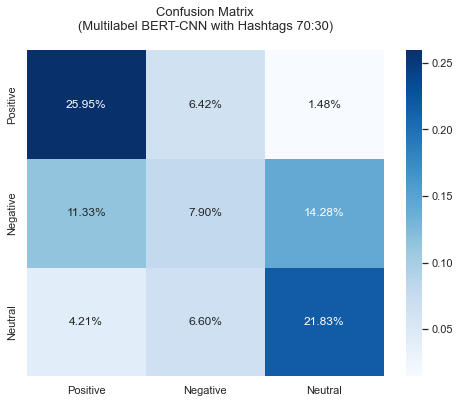

Epoch: 02

	Train Loss: 0.941
	Test Loss: 0.929

	Accuracy: 0.5907 | F1-Score: 0.5780
	Precision: 0.5745 | Recall: 0.5903

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.6721    0.7962    0.7289       780
    Negative     0.4564    0.3459    0.3935       772
     Neutral     0.5950    0.6290    0.6115       752

    accuracy                         0.5907      2304
   macro avg     0.5745    0.5903    0.5780      2304
weighted avg     0.5746    0.5907    0.5782      2304


[[621 129  30]
 [213 267 292]
 [ 90 189 473]]


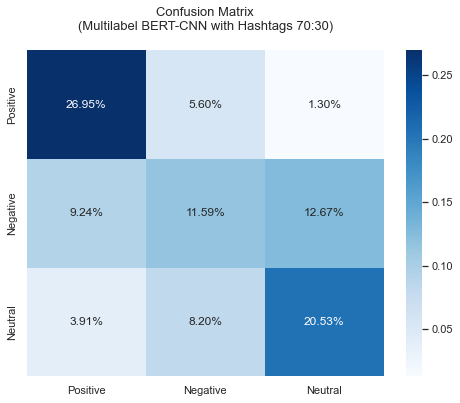

Epoch: 03

	Train Loss: 0.880
	Test Loss: 0.917

	Accuracy: 0.6107 | F1-Score: 0.6015
	Precision: 0.5982 | Recall: 0.6107

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.7104    0.7769    0.7422       780
    Negative     0.4756    0.3795    0.4222       772
     Neutral     0.6084    0.6755    0.6402       752

    accuracy                         0.6107      2304
   macro avg     0.5982    0.6107    0.6015      2304
weighted avg     0.5985    0.6107    0.6017      2304


[[606 145  29]
 [181 293 298]
 [ 66 178 508]]


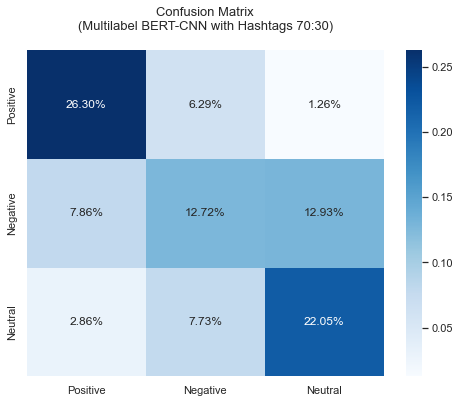

Epoch: 04

	Train Loss: 0.834
	Test Loss: 0.923

	Accuracy: 0.6068 | F1-Score: 0.6114
	Precision: 0.6196 | Recall: 0.6066

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.7616    0.6756    0.7160       780
    Negative     0.4627    0.5298    0.4940       772
     Neutral     0.6346    0.6144    0.6243       752

    accuracy                         0.6068      2304
   macro avg     0.6196    0.6066    0.6114      2304
weighted avg     0.6200    0.6068    0.6117      2304


[[527 230  23]
 [120 409 243]
 [ 45 245 462]]


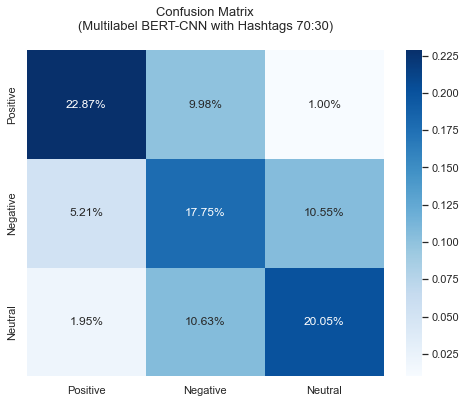

Epoch: 05

	Train Loss: 0.796
	Test Loss: 0.915

	Accuracy: 0.6163 | F1-Score: 0.6182
	Precision: 0.6236 | Recall: 0.6156

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.7295    0.7295    0.7295       780
    Negative     0.4786    0.5350    0.5052       772
     Neutral     0.6626    0.5824    0.6200       752

    accuracy                         0.6163      2304
   macro avg     0.6236    0.6156    0.6182      2304
weighted avg     0.6236    0.6163    0.6186      2304


[[569 195  16]
 [152 413 207]
 [ 59 255 438]]


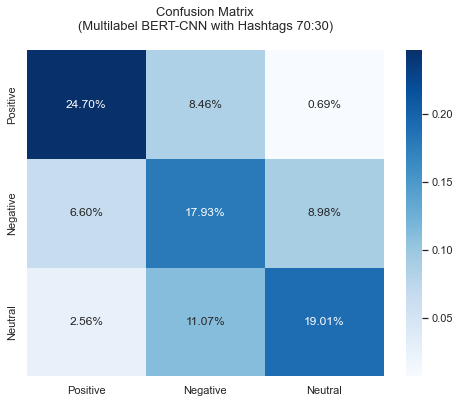

Epoch: 06

	Train Loss: 0.765
	Test Loss: 0.911

	Accuracy: 0.6220 | F1-Score: 0.6210
	Precision: 0.6242 | Recall: 0.6211

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.7122    0.7679    0.7390       780
    Negative     0.4920    0.5194    0.5054       772
     Neutral     0.6682    0.5758    0.6186       752

    accuracy                         0.6220      2304
   macro avg     0.6242    0.6211    0.6210      2304
weighted avg     0.6241    0.6220    0.6214      2304


[[599 164  17]
 [173 401 198]
 [ 69 250 433]]


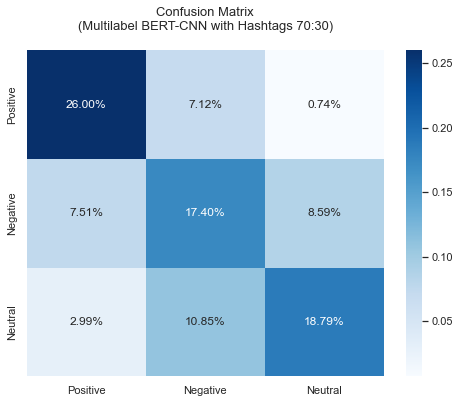

Epoch: 07

	Train Loss: 0.748
	Test Loss: 0.903

	Accuracy: 0.6345 | F1-Score: 0.6371
	Precision: 0.6418 | Recall: 0.6342

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.7520    0.7192    0.7353       780
    Negative     0.5023    0.5570    0.5283       772
     Neutral     0.6709    0.6263    0.6479       752

    accuracy                         0.6345      2304
   macro avg     0.6418    0.6342    0.6371      2304
weighted avg     0.6419    0.6345    0.6374      2304


[[561 197  22]
 [133 430 209]
 [ 52 229 471]]


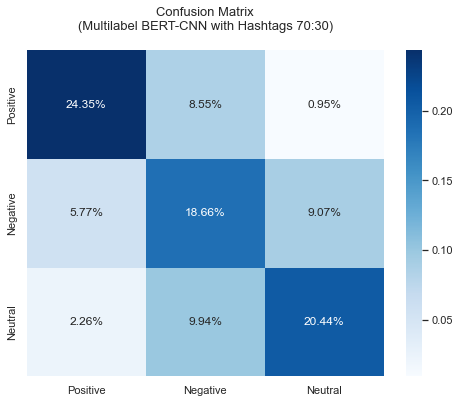

Epoch: 08

	Train Loss: 0.729
	Test Loss: 0.903

	Accuracy: 0.6332 | F1-Score: 0.6350
	Precision: 0.6397 | Recall: 0.6326

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.7461    0.7385    0.7423       780
    Negative     0.5023    0.5583    0.5288       772
     Neutral     0.6706    0.6011    0.6339       752

    accuracy                         0.6332      2304
   macro avg     0.6397    0.6326    0.6350      2304
weighted avg     0.6398    0.6332    0.6354      2304


[[576 182  22]
 [141 431 200]
 [ 55 245 452]]


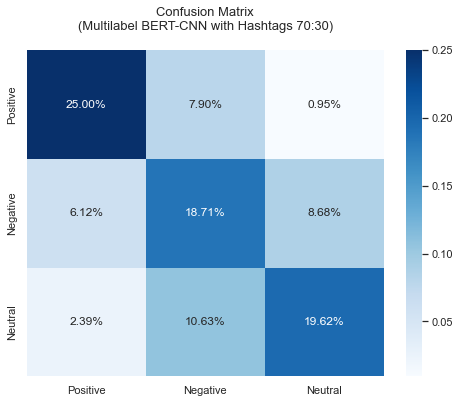

Epoch: 09

	Train Loss: 0.713
	Test Loss: 0.899

	Accuracy: 0.6411 | F1-Score: 0.6424
	Precision: 0.6497 | Recall: 0.6402

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.7380    0.7513    0.7446       780
    Negative     0.5136    0.5868    0.5478       772
     Neutral     0.6975    0.5824    0.6348       752

    accuracy                         0.6411      2304
   macro avg     0.6497    0.6402    0.6424      2304
weighted avg     0.6496    0.6411    0.6428      2304


[[586 174  20]
 [149 453 170]
 [ 59 255 438]]


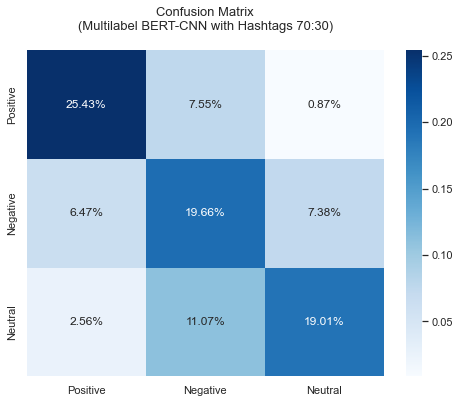

Epoch: 10

	Train Loss: 0.704
	Test Loss: 0.914

	Accuracy: 0.6254 | F1-Score: 0.6319
	Precision: 0.6547 | Recall: 0.6250

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.7828    0.6423    0.7056       780
    Negative     0.4850    0.6503    0.5556       772
     Neutral     0.6963    0.5824    0.6343       752

    accuracy                         0.6254      2304
   macro avg     0.6547    0.6250    0.6319      2304
weighted avg     0.6548    0.6254    0.6321      2304


[[501 259  20]
 [ 99 502 171]
 [ 40 274 438]]


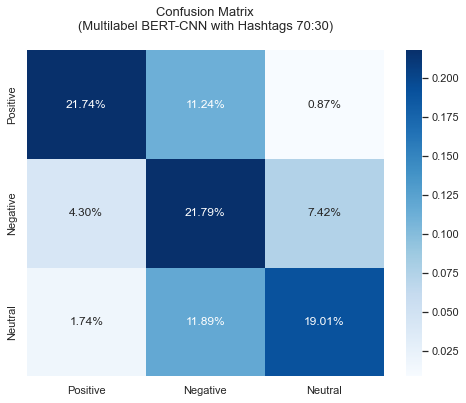

In [32]:
from sklearn.metrics import classification_report

N_EPOCHS = 10
predicted_sentiments_per_epoch = []
true_sentiments_per_epoch = []

for epoch in range(N_EPOCHS):
    train_loss = train(model, train_iterator)
    test_loss, accuracy, f1, precision, recall, predicted_sentiments, true_sentiments = evaluate(model, test_iterator)
    
    # Save the predicted_sentiments and true_sentiments for the current epoch
    predicted_sentiments_per_epoch.append(predicted_sentiments)
    true_sentiments_per_epoch.append(true_sentiments)

    # Print other metrics (e.g., accuracy, loss) for the current epoch
    print(f'Epoch: {epoch + 1:02}\n')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\tTest Loss: {test_loss:.3f}\n')
    print(f'\tAccuracy: {accuracy:.4f} | F1-Score: {f1:.4f}')
    print(f'\tPrecision: {precision:.4f} | Recall: {recall:.4f}\n')
    print(f'\tClassification Report:\n')
    report = classification_report(true_sentiments, predicted_sentiments, target_names=['Positive', 'Negative', 'Neutral'], digits = 4)
    print(f'{report}\n')
    
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np  # Import numpy for matrix normalization

    # Calculate the confusion matrix
    cf_matrix = confusion_matrix(true_sentiments, predicted_sentiments)
    print(cf_matrix)

    # Plot the confusion matrix using seaborn
    sns.set(rc={"figure.figsize": (8, 6)})  # Add a closing parenthesis to set
    ax = sns.heatmap(cf_matrix / np.sum(cf_matrix), annot=True, xticklabels=['Positive', 'Negative', 'Neutral'], yticklabels=['Positive', 'Negative', 'Neutral'], fmt='.2%', cmap='Blues')

    plt.title('Confusion Matrix\n(Multilabel BERT-CNN with Hashtags 70:30)\n', fontsize=13)
    plt.show()